In [1]:
# import tensorflow as tf
# sess = tf.Session()
import itertools
import keras
from keras import backend as K
# K.set_session(sess)
import h5py

from keras.models import Model
from keras.layers import Dense, LSTM, Input, Embedding, GRU, Masking, Dropout, Lambda, Flatten, concatenate, Conv1D, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import pad_sequences

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

# import pandas 

from process_data import *
from model_saving import load_model_char
import os
# from n_gram_lm import *

# import kenlm

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10591311558206198795
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11324823962
locality {
  bus_id: 1
}
incarnation: 7908079745714042637
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [3]:
# Problem parameters
max_input_len = 550
max_label_len = 280
max_ratio = 5
n_energies = 20
n_chars = 27+1 # 27 chars including space, 1 blank
blank_idx = n_chars - 1

In [4]:
model_name = "densenet_char_b3.l5.f128.k7.relu"

In [5]:
model, highest_epoch = load_model_char(model_name, mode="best")

Loading model densenet_char_b3.l5.f128.k7.relu
Compiling...
Looking for weight files with mode "best"
File densenet_char_b3.l5.f128.k7.relu-18-66.9498682517.hdf5 contains weights after 18 epochs achieving validation loss: 66.9498682517
File densenet_char_b3.l5.f128.k7.relu-14-68.8587954198.hdf5 contains weights after 14 epochs achieving validation loss: 68.8587954198
File densenet_char_b3.l5.f128.k7.relu-15-69.2541061082.hdf5 contains weights after 15 epochs achieving validation loss: 69.2541061082
File densenet_char_b3.l5.f128.k7.relu-6-81.3153245907.hdf5 contains weights after 6 epochs achieving validation loss: 81.3153245907
File densenet_char_b3.l5.f128.k7.relu-16-66.3162421146.hdf5 contains weights after 16 epochs achieving validation loss: 66.3162421146
File densenet_char_b3.l5.f128.k7.relu-3-94.5454798789.hdf5 contains weights after 3 epochs achieving validation loss: 94.5454798789
File densenet_char_b3.l5.f128.k7.relu-20-65.1938572416.hdf5 contains weights after 20 epochs achie

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
mfccs (InputLayer)               (None, 550, 20)       0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 550, 128)      18048       mfccs[0][0]                      
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 550, 128)      512         conv1d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 550, 128)      0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [7]:
inputs, outputs, ids = get_test_data_char(n_chars, max_label_len, max_input_len)

# print inputs_valid.keys()
X = inputs["mfccs"]
input_lengths= inputs["input_lens"]
y= inputs["labels"]
label_lengths= inputs["label_lens"]


In [8]:
y[2]

array([20,  8,  5, 25,  0, 23,  5, 18,  5,  0,  1,  2, 19, 15, 18,  2,  5,
        4,  0,  9, 14,  0,  8,  9, 19,  0, 20,  8,  5, 15, 12, 15,  7, 25,
        0,  1, 14,  4,  0, 23,  5, 18,  5,  0, 21, 14,  4,  5, 18,  0, 20,
        8,  5,  0,  4, 15, 13,  9, 14,  9, 15, 14,  0, 15,  6,  0,  8,  9,
       19,  0, 14,  1, 13,  5,  0, 23,  8,  9, 12,  5,  0, 20,  8,  1, 20,
        0, 23,  8,  9,  3,  8,  0, 23,  1, 19,  0, 20, 18, 21, 12, 25,  0,
        7, 18,  5,  1, 20,  0,  1, 14,  4,  0, 20, 18, 21, 12, 25,  0,  3,
        8,  1, 18,  1,  3, 20,  5, 18,  9, 19, 20,  9,  3,  0,  9, 14,  0,
        8,  9, 13,  0,  8,  9, 19,  0,  5,  6,  6, 15, 18, 20,  0, 20, 15,
        0, 18,  5,  1, 12,  9, 26,  5,  0,  1, 14,  4,  0,  3, 15, 14, 14,
        5,  3, 20,  0,  1,  2, 19, 20, 18,  1,  3, 20,  9, 15, 14, 19,  0,
       23,  1, 19,  0, 14, 15, 20,  0, 21, 14,  4,  5, 18, 19, 20, 15, 15,
        4,  0,  2, 25,  0, 20,  8,  5, 13,  0,  1, 20,  0,  1, 12, 12, -1,
       -1, -1, -1, -1, -1

In [9]:
print np.median(input_lengths)

184.0


In [10]:
ctc_costs, char_probs = model.predict(inputs)
print np.mean(ctc_costs)
char_probs.shape

72.2315


(3821, 550, 28)

In [11]:
np.save(model_name+"_test_char_probs", char_probs)
np.save(model_name+"ctc_costs", char_probs)

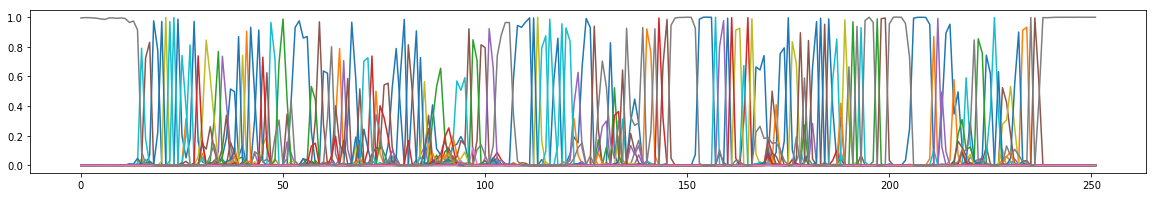

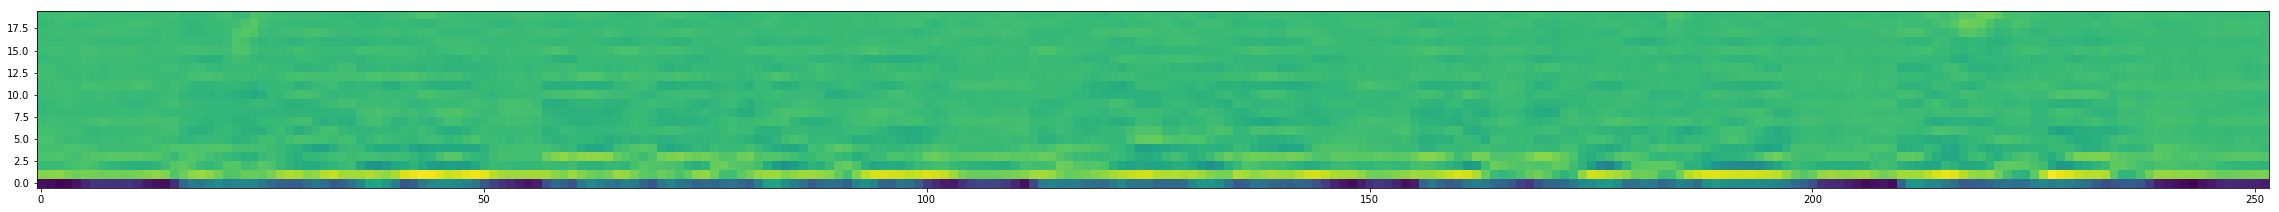

In [49]:
checking_idx = 3802
sample_id = ids[checking_idx]

sample_probs = char_probs[checking_idx]
sample_input_length = input_lengths[checking_idx]
sample_label_length = label_lengths[checking_idx]
sample_label = y[checking_idx]
sample_X = X[checking_idx]
sample_y = y[checking_idx]

plt.figure(figsize=(20,3))
plt.plot(sample_probs[:sample_input_length]);
fig, ax = plt.subplots(figsize=(40,100))
mfcc_data= np.swapaxes(sample_X[:input_lengths[checking_idx], ], 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest' , origin='lower')


In [50]:
# index to byte mapping
char_list = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
              'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q',
              'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-']

D = dict(zip(range(28), char_list))

# print "Sample id: {}".format(sample_id)
print
# Try the argmax acoustic-only decoder
print "Argmax chars:"
chars_w_repeats = [D[j] for j in np.argmax(sample_probs[:sample_input_length], axis=1)]
chars = [chars_w_repeats[0]]
for i,c in enumerate(chars_w_repeats):
    if c != chars[-1]:
        chars.append(c)
chars = [c for c in chars if c !='-']
print "".join(chars)
# Print the 'actual' text
print         
        
label = [D[j] for j in sample_y[:sample_label_length]]
print "Actual text :"
print "".join(label)
# 6319-275224-0019.flac

print "Normalized loss:"
print ctc_costs[checking_idx]


Argmax chars:
so this is wrld that woil be geade escame to the lwaseven this isn o lmy ame in which eu trye to survive and a litl stortage

Actual text :
so this is world without oil we made this game in two thousand and seven this is an online game in which you try to survive an oil shortage
Normalized loss:
[ 169.96595764]


In [48]:
phoneme_probs.shape

NameError: name 'phoneme_probs' is not defined

In [28]:
import tensorflow as tf

phoneme_probs_ = K.variable(phoneme_probs[[checking_idx]])#K.placeholder((None, max_input_len, n_phonemes), name="phoneme_probs")
input_lengths_ = K.variable(input_lengths[[checking_idx]])#K.placeholder(name='input_length',shape=(None, 1), dtype='int64')
top_paths, logp = K.ctc_decode(y_pred=phoneme_probs_, 
                               input_length=input_lengths_, 
                               greedy=False, 
                               beam_width=10**4, 
                               top_paths=10000)

# print X_.shape
# print input_lengths_.shape
sess = tf.Session()
sess.run(tf.global_variables_initializer())
P, L = sess.run([top_paths,logp])

In [29]:
L

array([[ 12.98721504,  12.93417358,  12.86686897, ...,  10.28051853,
         10.28046894,  10.28046799]], dtype=float32)

In [38]:
np.savez("10k_paths", *P)

In [39]:
sample_id

'2961-960-0017.flac'

In [45]:
P_check = P[9][checking_idx]
print P_check.shape
phon_check = code_to_phonemes([x for x in P_check if x!=-1])
# print phon_check
# assert phon_check == [x for x in phonemes if x!="-"]
print "".join([x for x in phon_check if x!="-"])
print "".join([x for x in phonemes if x!="-"])

(174,)
DHAHFAENSIYZAHVDHAHNYUWPLAEKNAHSTAAROWLEYIHNTRAHSTIHNTUWAWSBIHKAOZDHEYIHKSAHTAHFEYZAHVDHAHHHYUWMAHNMAYWIHCHRIYVEYLWAYTLIYDHAHFERSTSEHNTERIYZAHVDHAHKRIHSCHAHNIHRAHNDIHZNAATHHOWLIYEHTSIHNGKTIHNAWTOWNDHEY
DHAHFAENSIYZAHVDHAHNUWPLAEKNAHSTAAROWLEYIHNTRAHSTIHNTUWAWSBIHKAOZDHEYIHKSAHAHTAHFEYZAHVDHAHHHYUWMAHTMAYWIHCHRIYEYLWAYTLIYDHAHFERSTSEHNCHERIYZAHVDHAHKRIHSCHAHNIHRAHAHNDIHZNAATHHOWLIYEHTSEYNGKTIHNAWTOWNDHEY


In [75]:
cmudict = nltk.corpus.cmudict.dict()
language = cmudict.keys()

In [76]:
cmudict["don't"]

[[u'D', u'OW1', u'N', u'T'], [u'D', u'OW1', u'N']]

In [48]:
n_paths = 100
alpha = 1.25
beta = 0.1            
step_size = 5
candidates = beam_search_word(sample_probs, sample_input_length, language_score, alpha, beta, n_paths, step_size)

Starting beam search with input of length 258 ...
Reached t = 0
Found top 100 candidates
Checking extensions of "" which has current score 0.0
[u'fawn']
[u'F', u'AO', u'N']


AttributeError: 'list' object has no attribute 'shape'